In [1]:
using Pkg
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt=PyPlot
# Install Conda package python-ternary: using Conda; Conda.add("python-ternary")
ternary = pyimport("ternary")

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/UROP/SAFT_codes/Clapeyron`


PyObject <module 'ternary' from '/Users/pierrewalker/Library/Python/3.9/lib/python/site-packages/ternary/__init__.py'>

## Methanol+hexane+benzene

In [14]:
model = UNIFAC(["water",("dichloromethane",["CH2CL2"=>1]),("acetone",["CH3"=>1,"CH3CO"=>1])])

UNIFAC{PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule}} with 3 components:
 "water": "H2O" => 1
 "dichloromethane": "CH2CL2" => 1
 "acetone": "CH3" => 1, "CH3CO" => 1
Group Type: UNIFACDortmund
Contains parameters: A, B, C, R, Q

In [15]:
p=1e5
T=298.15
K0 = [1000.,0.001,0.001]
(x,n,G) = tp_flash(model,p,T,[0.5,0.5,1e-10],RRTPFlash(K0=K0,equilibrium=:lle))

([0.994181334972218 0.005818665016614499 1.1167552840234215e-11; 0.009492840321071555 0.9905071594907564 1.8817198918979348e-10], [0.49523586948646936 0.002898476894895747 5.562941634811553e-12; 0.004764130513328384 0.49710152310530653 9.44370583652248e-11], -6.933548559268726)

In [26]:
T = 298.15
p = 1e5
z0 = [0.5,0.5,1e-10]
ϕ = 0.75

K0 = [1000.,0.0001,0.001]
dz = 1e-3
x_LLE = zeros(500,6)
idxend = 500
for i in 1:500
    (x,n,G) = tp_flash(model,p,T,z0,RRTPFlash(K0=K0,equilibrium=:lle))
    x_LLE[i,1:3] = x[1,:]
    x_LLE[i,4:6] = x[2,:]
    K0 = [x[1,1]/x[2,1],x[1,2]/x[2,2],x[1,3]/x[2,3]]
    z0[1:2] = x[1,1:2]*ϕ+x[2,1:2]*(1-ϕ)
    z0[3] = z0[3] + dz
    if x[1,1]-x[2,1] < 1e-3
        idxend=i-1
        break
    end
end

x_LLE = vcat(x_LLE[1:idxend,1:3],reverse(x_LLE[1:idxend,4:6],dims=1));

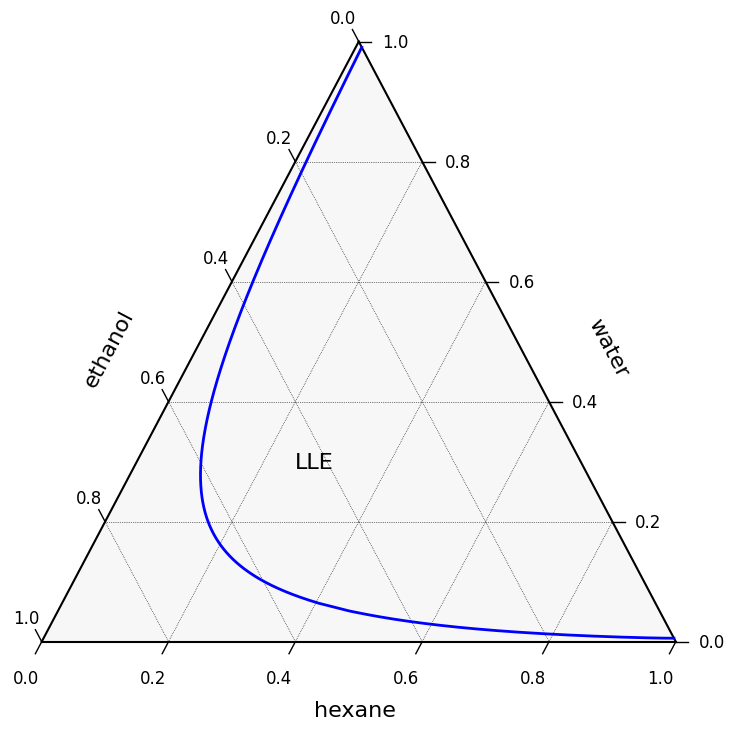

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [27]:
plt.clf()
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 9)

tax.boundary()
tax.gridlines(multiple=0.2, color="black")
tax.left_axis_label("ethanol", fontsize=16, offset=0.15)
tax.right_axis_label("water", fontsize=16, offset=0.15)
tax.bottom_axis_label("hexane", fontsize=16, offset=0.02)

# Plot the data
tax.plot(x_LLE, linewidth=2.0,color="b",linestyle="-", label="")


tax.ticks(axis="lbr", multiple=0.2, linewidth=1,fontsize=12, tick_formats="%.1f", offset=0.02)

ax = plt.gca()

ax.text(0.4, 0.25, "LLE",fontsize=16)

tax.get_axes().axis("off")
tax.clear_matplotlib_ticks()
tax.legend(loc="upper right",frameon=false,fontsize=14)
# tax.savefig("MeOH_Benz_Hx_tern.pdf")
display(plt.gcf())

## Cyclohexane+methanol+carbon dioxide

In [159]:
model = PCSAFT(["cyclohexane","methanol","propane"])


PCSAFT{BasicIdeal, Float64} with 3 components:
 "cyclohexane"
 "methanol"
 "propane"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

In [160]:
T = 303.15
p = 1e5
(x3,n3,G3) = tp_flash(model,p,T,[0.33,0.33,0.34],DETPFlash(numphases=3))

([0.2611980433620865 0.706145034409113 0.03265692222880062; 0.7459441631097545 0.19628874487303252 0.057767092017212925; 0.15185499580233716 0.19849642657489877 0.6496485776227641], [0.06794814297361601 0.18369679627203514 0.008495382247579628; 0.18796537111117478 0.04946145918106426 0.014556334677601312; 0.07408648591520924 0.09684174454690062 0.3169482830748191], -6.245675362387845)

### LLE between methanol and cyclohexane

In [163]:
K0 = [x3[1,1]/x3[2,1],x3[1,2]/x3[2,2],x3[1,3]/x3[2,3]]
z0 = (x3[1,:]+x3[2,:])/2
dz = z0[3]/200
x_LLE = zeros(200,6)

for i in 1:200
    z0[3] = z0[3] - dz
    (x,n,G) = tp_flash(model,p,T,z0,MichelsenTPFlash(K0=K0,equilibrium=:lle))
    x_LLE[i,1:3] = x[1,:]
    x_LLE[i,4:6] = x[2,:]
    K0 = [x[1,1]/x[2,1],x[1,2]/x[2,2],x[1,3]/x[2,3]]
    z0[1:2] = (x[1,1:2]+x[2,1:2])/2
end

### VLE between methanol and carbon dioxide

In [164]:
N = 1000
K0 = [x3[1,1]/x3[3,1],x3[1,2]/x3[3,2],x3[1,3]/x3[3,3]]
z0 = (x3[1,:]+x3[3,:])/2
dz = z0[1]/N
x_VLE1 = zeros(N,6)

for i in 1:N
    z0[1] = z0[1] - dz
    (x,n,G) = tp_flash(model,p,T,z0,RRTPFlash(K0=K0,equilibrium=:vle))
    idx_min = argmin(x[:,2])
    idx_max = argmax(x[:,2])
    x_VLE1[i,1:3] = x[idx_min,:]
    x_VLE1[i,4:6] = x[idx_max,:]
    K0 = x_VLE1[i,1:3]./x_VLE1[i,4:6]
    z0[2:3] = (x[1,2:3]+x[2,2:3])/2
end

### VLE between cyclohexane and carbon dioxide

In [165]:
K0 = [x3[2,1]/x3[3,1],x3[2,2]/x3[3,2],x3[2,3]/x3[3,3]]
z0 = (x3[2,:]+x3[3,:])/2
dz = z0[2]/100
x_VLE2 = zeros(100,6)

for i in 1:100
    z0[2] = z0[2] - dz
    (x,n,G) = tp_flash(model,p,T,z0,RRTPFlash(K0=K0,equilibrium=:vle))
    x_VLE2[i,1:3] = x[1,:]
    x_VLE2[i,4:6] = x[2,:]
    K0 = [x[1,1]/x[2,1],x[1,2]/x[2,2],x[1,3]/x[2,3]]
    z0[[1,3]] = (x[1,[1,3]]+x[2,[1,3]])/2
end

### Plotting

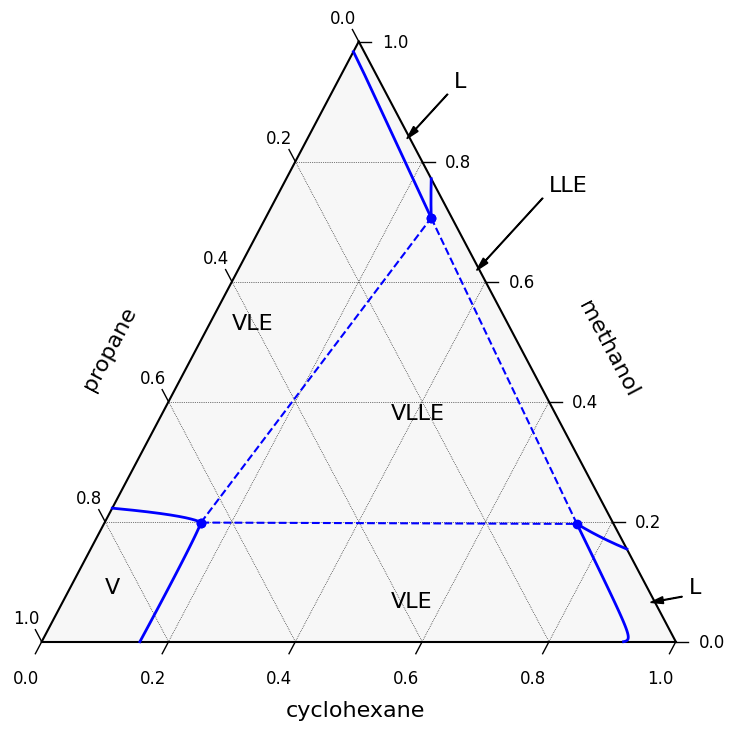

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [166]:
plt.clf()
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 9)

tax.boundary()
tax.gridlines(multiple=0.2, color="black")
tax.left_axis_label("propane", fontsize=16, offset=0.15)
tax.right_axis_label("methanol", fontsize=16, offset=0.15)
tax.bottom_axis_label("cyclohexane", fontsize=16, offset=0.02)

# Plot the data
tax.plot(x_LLE[:,1:3], linewidth=2.0,color="b",linestyle="-", label="")
tax.plot(x_LLE[:,4:6], linewidth=2.0,color="b",linestyle="-", label="")

tax.plot(x_VLE1[:,1:3], linewidth=2.0,color="b",linestyle="-", label="")
tax.plot(x_VLE1[:,4:6], linewidth=2.0,color="b",linestyle="-", label="")

tax.plot(x_VLE2[:,1:3], linewidth=2.0,color="b",linestyle="-", label="")
tax.plot(x_VLE2[:,4:6], linewidth=2.0,color="b",linestyle="-", label="")

tax.plot(x3,color="b",linestyle="--",marker="o", label="")
tax.plot(x3[[3,1],:],color="b",linestyle="--",marker="o", label="")


tax.ticks(axis="lbr", multiple=0.2, linewidth=1,fontsize=12, tick_formats="%.1f", offset=0.02)

ax = plt.gca()

ax.text(0.55, 0.32, "VLLE",fontsize=16)
ax.text(0.3, 0.45, "VLE",fontsize=16)
ax.text(0.55, 0.05, "VLE",fontsize=16)

ax.text(0.8, 0.65, "LLE",fontsize=16)
ax.arrow(0.79, 0.64, -0.09, -0.09, head_width=0.01, head_length=0.02, fc="k", ec="k")


ax.text(0.1, 0.07, "V",fontsize=16)
ax.text(0.65, 0.8, "L",fontsize=16)
ax.arrow(0.64, 0.79, -0.05, -0.05, head_width=0.01, head_length=0.02, fc="k", ec="k")
ax.text(1.02, 0.07, "L",fontsize=16)
ax.arrow(1.01, 0.065, -0.03, -0.005, head_width=0.01, head_length=0.02, fc="k", ec="k")

tax.get_axes().axis("off")
tax.clear_matplotlib_ticks()
tax.legend(loc="upper right",frameon=false,fontsize=14)
# tax.savefig("MeOH_Benz_Hx_tern.pdf")
display(plt.gcf())